In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob

import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend
from IPython.display import clear_output
from scipy.interpolate import CubicSpline

from utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

plt.style.use('sg_article')


In [2]:
def analyze_sfac_interactive(kbins, sfac_av, act_idx=0, pval_min=0.05, Npoints_bounds = [3,8], verbose=True):
    """
    returns fit_params_time_av, fit_params_unweighted
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    fit_string = rf'$y = \beta + \alpha |k|$'
    Nparams = len(param_guess)

    fit_params_sfac_time_av = np.zeros([2 * Nparams]) * np.nan
    fit_params_unweighted = np.zeros([2 * Nparams]) * np.nan

    i = act_idx
    it_max = 50
    sfac_nan_mask = np.isnan(sfac_av[:, i, 0])
    try:
        x = np.log(kbins[~sfac_nan_mask])
        y = np.log(sfac_av[~sfac_nan_mask, i, 0])
        yerr = sfac_av[~sfac_nan_mask, i, 1] / sfac_av[~sfac_nan_mask, i, 0] 
    except:
        return None, None

    fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
    fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

        for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])): 
            it = 0        
            yerr_mod = yerr.astype(float)   
            while it < it_max:
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr_mod[:Npoints_to_fit],
                                    param_guess, verbose = False)
                Ndof, chi2, pval = get_statistics_from_fit(fit, len(x[:Npoints_to_fit]), subtract_1dof_for_binning = False)

                it += 1
                yerr_mod *= 1.05 # * yerr #np.sqrt(np.sqrt(it))
             #   print(f'it: {it}, Npoints: {Npoints_to_fit}, alpha: {fit.values[0]} +/- {fit.errors[0]}, chi2: {chi2}, pval: {pval}')
                
            #   print(f'it: {it}, Npoints: {Npoints_to_fit}, alpha: {fit.values[0]} +/- {fit.errors[0]}, chi2: {chi2}, pval: {pval}')
                if pval > pval_min:
                    fit_vals[j] = fit.values[:] 
                    fit_err[j] = fit.errors[:]
                    break
            if verbose:
                print(f'it: {it}, Npoints: {Npoints_to_fit}, alpha: {fit.values[0]} +/- {fit.errors[0]}, chi2: {chi2}, pval: {pval}')
        
        nan_mask = np.isnan(fit_vals[:,0])
        fit_vals_valid = fit_vals[~nan_mask]
        fit_err_valid = fit_err[~nan_mask]
        Nfits_valid = fit_vals_valid.shape[0]
 
        if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
            return None, None

        if Nfits_valid == 1:
            fit_params_sfac_time_av[:Nparams] = fit_vals_valid[:]
            fit_params_sfac_time_av[Nparams:] = fit_err_valid[:]
            fit_params_unweighted = fit_params_sfac_time_av
        else:  
            alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
            beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
            alpha_sem *= np.sqrt(Nfits_valid)
            beta_sem *= np.sqrt(Nfits_valid)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                fit_params_sfac_time_av[:Nparams] = alpha_weighted_av, beta_weighted_av
                fit_params_sfac_time_av[Nparams:] = alpha_sem, beta_sem
                fit_params_unweighted[:Nparams] = np.nanmean(fit_vals_valid, axis = 0)   
                fit_params_unweighted[Nparams:] = np.nanstd(fit_vals_valid, axis = 0)
    return fit_params_sfac_time_av, fit_params_unweighted

In [3]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

LL = 2048
output_path = f'data\\na{LL}'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [263]:

act_fit_list = [0.0215, 0.022,]
pval_min = 0.01
npoints_to_fit = [4, 4, 5, 7]
npoints_to_fit = [4, 4, 6, 7]
alpha_scaling = np.zeros([len(system_size_list), len(act_fit_list), 2])
alpha_scaling_av = np.zeros([len(system_size_list), len(act_fit_list), 2])
for j, LL in enumerate(system_size_list):
    print(f"LL = {system_size_list[j]}")
    output_path = f'data\\na{LL}'
    mode = 'all' # 'all' or 'short'

    defect_list = gen_analysis_dict(LL, mode)
    ad = AnalyseDefects(defect_list, output_path=output_path)


    kbins, sfac = ad.get_sfac_pcf_full(-1)[:2]
    act_list = ad.act_list[-1]

    sfac_exp_av = np.zeros([len(kbins), len(act_list), 2])

    for nact, act in enumerate(act_fit_list):
    
      act_idx = act_list.index(act) 
      ff_idx = ad.conv_list[-1][act_idx]
      if LL < 1000:
        Npoints_bounds = [npoints_to_fit[j], npoints_to_fit[j] + 1]
      elif LL == 1024:
        Npoints_bounds = [npoints_to_fit[j], npoints_to_fit[j] + 1]
      else:    
        Npoints_bounds = [npoints_to_fit[j], npoints_to_fit[j] + 1] 
      Nind = 20

      with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sfac_tav = np.nanmean(sfac[ff_idx:], axis = 0)
        sfac_tav_err = np.nanstd(sfac[ff_idx:], axis = 0) / np.sqrt(sfac[ff_idx:].shape[0] / Nind)
        sfac_tav = np.concatenate([sfac_tav[:,:,:,None], sfac_tav_err[:,:,:,None]], axis = -1)

        sfac_exp_av[:,act_idx,0], sfac_exp_av[:,act_idx,1] = calc_weighted_mean(sfac_tav[:,act_idx, :, 0], sfac_tav[:, act_idx, :, 1], axis=-1)

        fit_params_exp_av, _ = analyze_sfac_interactive(kbins, sfac_exp_av, act_idx=act_idx, 
                                                                              pval_min=pval_min, Npoints_bounds = Npoints_bounds,
                                                                              verbose=True)
        alpha_scaling_av[j,nact] = fit_params_exp_av[0], fit_params_exp_av[-2]

      #kbins, sfac_av, act_idx=0, pval_min=0.05, Npoints_bounds = [3,8],)
      fit_vals = np.zeros([sfac_tav.shape[-2], 2])

      for i in range(sfac_tav.shape[-2]):
    #      print("EXP ", i)
          fit_params_time_av, fit_params_unweighted = analyze_sfac_interactive(kbins, sfac_tav[:,:,i,:], act_idx=act_idx, 
                                                                              pval_min=pval_min, Npoints_bounds = Npoints_bounds,
                                                                              verbose=False)
        #  print(fit_params_time_av[0], "\pm", fit_params_time_av[-2])
          fit_vals[i] = fit_params_time_av[0], fit_params_time_av[-2]
          
        # fit_params_unweighted
      fit_weighted_av, fit_sem = calc_weighted_mean(fit_vals[:,0], fit_vals[:,1])
      alpha_scaling[j,nact] = fit_weighted_av, fit_sem
      print("WEIGHTED", fit_weighted_av, "\pm", fit_sem)


LL = 256
it: 1, Npoints: 4, alpha: -0.042346106521245014 +/- 0.015745904720936624, chi2: 1.003985785729623, pval: 0.6053231127441314
WEIGHTED -0.046207290164655954 \pm 0.016582942488929067
it: 16, Npoints: 4, alpha: -0.05510499383413038 +/- 0.03481995998067586, chi2: 8.424579008593446, pval: 0.014812416395376274
WEIGHTED -0.05723199677599384 \pm 0.01756176493418618
LL = 512
it: 11, Npoints: 4, alpha: -0.17402454067688874 +/- 0.027498511687319857, chi2: 9.132189159997322, pval: 0.010398490994982315
WEIGHTED -0.2103999895359123 \pm 0.021354575944241987
it: 26, Npoints: 4, alpha: -0.49571314451975934 +/- 0.055970607614434516, chi2: 8.834809698943891, pval: 0.012065503488181832
WEIGHTED -0.505735815388446 \pm 0.020094527978717594
LL = 1024
it: 29, Npoints: 6, alpha: -0.3819608842238855 +/- 0.039021295212031314, chi2: 12.994886178732356, pval: 0.011300808034204253
WEIGHTED -0.4173758863621642 \pm 0.014222914300509822
it: 15, Npoints: 6, alpha: -0.7092990169561292 +/- 0.024510716471509042, c

C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


True
ndof chi2 prop:  2 0.1940937681750798 0.9075134571954756
k:  0.22385895533921443 +/- 0.06543517168873102
alpha:  -0.8142564314321757 +/- 0.141550154056636
True
ndof chi2 prop:  2 6.572358317082472 0.03739646272645085
k:  0.6608222781830773 +/- 0.07633132744249452
alpha:  -0.9021432228185275 +/- 0.02963876674107768


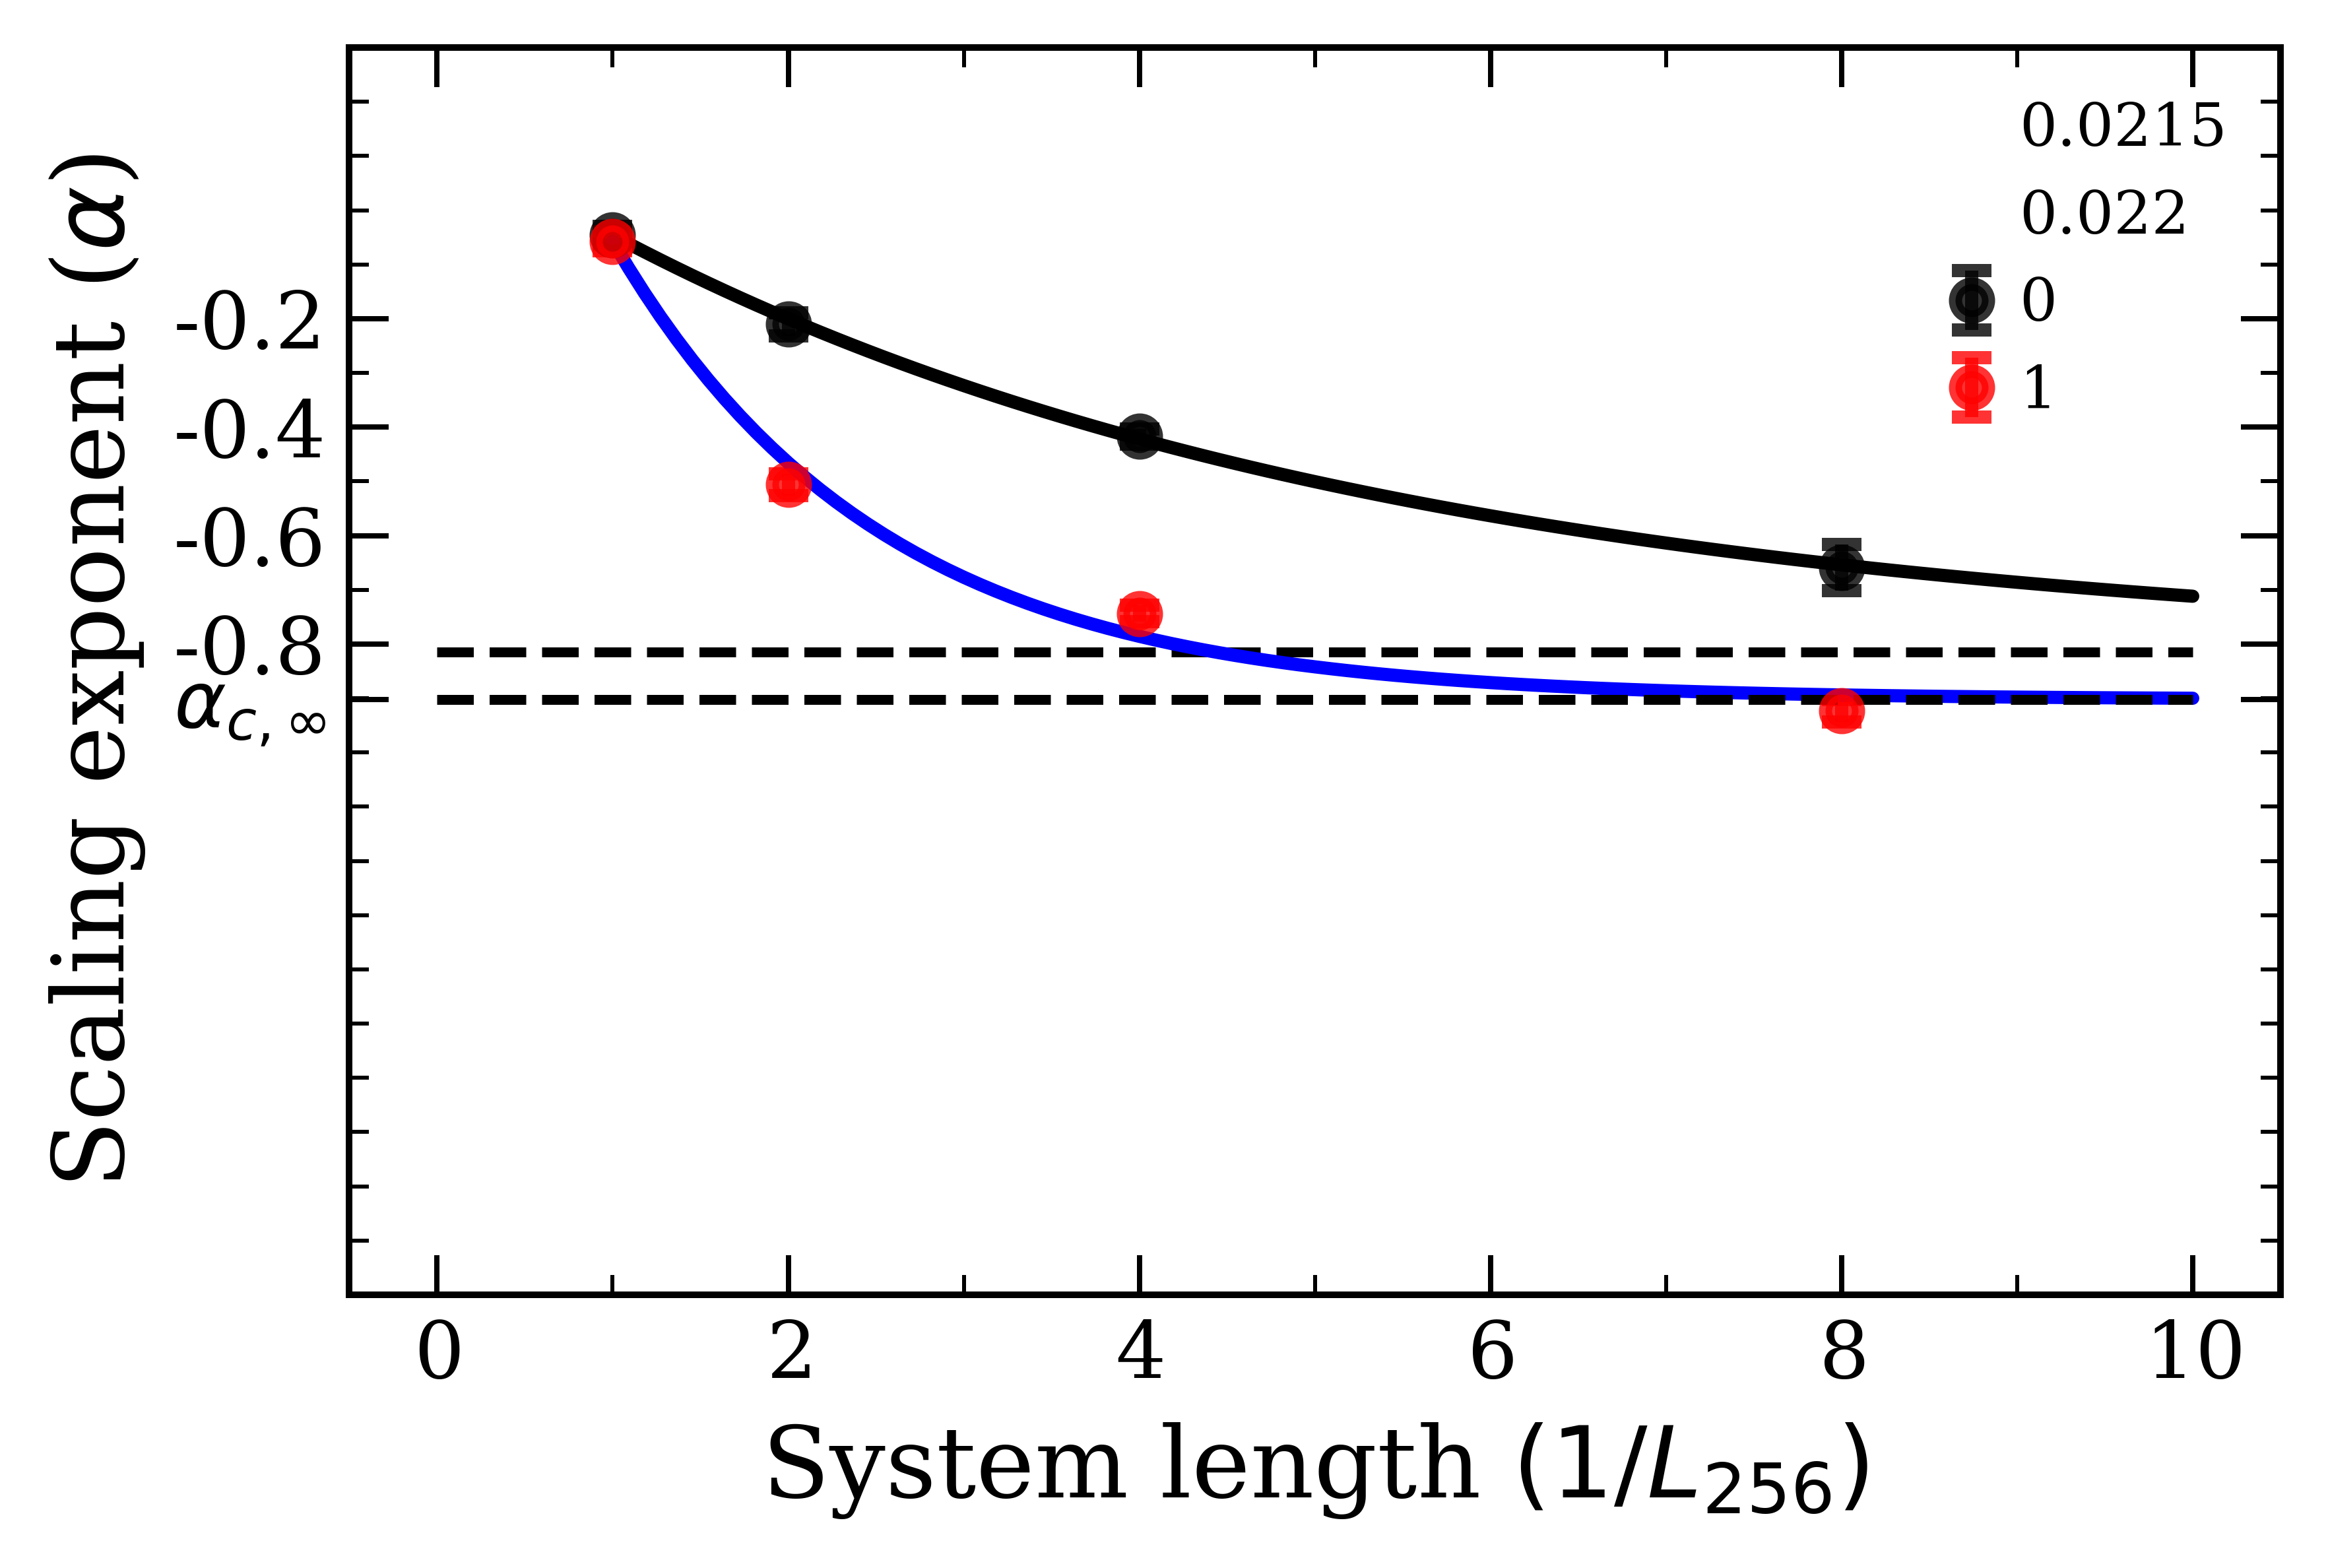

In [265]:

fig, ax = plt.subplots(figsize=(5,3.4))

acts_to_plot = act_fit_list
min_syst_idx = 0
normx = system_size_list[0]
LX_list_normed = [system_size_list[i] / normx for i in range(4-min_syst_idx)]

for i in range(len(act_fit_list)):
    X = np.array(LX_list_normed)
    Y = np.array(list(alpha_scaling[min_syst_idx:, i, 0]))
    dY = np.array(list(alpha_scaling[min_syst_idx:, i, 1]))
    cs = CubicSpline(X,Y, bc_type='natural')
    x = np.linspace(1,8,8)
    y = cs(x)
    dy = np.zeros_like(y)
    data_idx = [2, 4,5, 7]
    dy[[0, 1, 3, 7]] = dY
    zero_mask = (dy == 0)
    dy[zero_mask] = np.mean(dy[~zero_mask])


    ax.errorbar(X, Y, dY, fmt = 'o', label = rf'{i}', color = 'k' if i==0 else 'red',\
            markersize = 5, alpha = .8, elinewidth = 2, capsize = 3, markeredgewidth = 2)

    x0 = 0.9

    fit_func_exp = lambda x, k, c: c * (1 - np.exp(-k*(x-1)))
    fit_label = r'$\alpha_c(L) = \alpha_c(L_{256}) + \alpha_{c,\infty}(1 - \exp[-\kappa(L - L_{256})])$'

    param_guess = [.5, -1,]
    point_bounds = [50,250]
    xlim = [0, 10]
    #ax.set(yticks = yticks, yticklabels = yticklabels, xlim=xlim)

    x_plot_fit = np.linspace(X[0],xlim[-1],100)
    fit_exp = do_chi2_fit(fit_func_exp, X, Y - Y[0], np.sqrt(dY**2 + dY[0]**2), param_guess, verbose = False)
    print(fit_exp._fmin.is_valid)

    yticks = [fit_exp.values['c'] + Y[0], -0.8, -0.6, -0.4, -0.2]
    yticklabels = [r'$\alpha_{c,\infty}$', -0.8, -0.6, -0.4, -0.2]
    ax.set_xlabel(r'System length $(1/L_{256})$', fontsize=15)
    ax.set_ylabel(r'Scaling exponent ($\alpha$)', fontsize=15)
    ax.plot(x_plot_fit, fit_func_exp(x_plot_fit, *fit_exp.values[:]) + Y[0], '-', color = 'k' if i==0 else 'b', label = f'{acts_to_plot[i]}') #fit_label) #
  
    ax.set(yticks = yticks, yticklabels = yticklabels, ylim=[-2,0.3])#xlim=[0,40])
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    ax.hlines(fit_exp.values['c'] + Y[0], 0,10, lw=1.5,color = 'black', linestyle = '--',)# label = rf'$\alpha_c = {(fit_exp.values["c"]+Y[0]):.2f}$')
    Ndof, chi2, prop = get_statistics_from_fit(fit_exp, len(X),)
    print("ndof chi2 prop: ", Ndof, chi2, prop)
    #ax.set_yscale(('log'))
    ax.legend(fontsize=9)
    fig.tight_layout()
    fig.dpi = 720
    #ax.set_xscale('log', base=2)
    print("k: ", fit_exp.values['k'], "+/-", fit_exp.errors['k'])  
    print("alpha: ", fit_exp.values['c'] + Y[0], "+/-", fit_exp.errors['c'])
    #print(fit_exp.values['L0'], "+/-", fit_exp.errors['L0'])

In [ ]:
act = 0.0215

for j, LL in enumerate(system_size_list):
    output_path = f'data\\na{LL}'
    mode = 'all' # 'all' or 'short'

    defect_list = gen_analysis_dict(LL, mode)
    ad = AnalyseDefects(defect_list, output_path=output_path)


    kbins, sfac = ad.get_sfac_pcf_full(-1)[:2]
    act_list = ad.act_list[-1]


    act_idx = act_list.index(act) 
    ff_idx = ad.conv_list[-1][act_idx]
    Npoints_bounds = [4,5] if LL < 2038 else [5,6]
    Nind = 20

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sfac_tav = np.nanmean(sfac[ff_idx:], axis = 0)
        sfac_tav_err = np.nanstd(sfac[ff_idx:], axis = 0) / np.sqrt(sfac[ff_idx:].shape[0] / Nind)
        sfac_tav = np.concatenate([sfac_tav[:,:,:,None], sfac_tav_err[:,:,:,None]], axis = -1)

    sfac_exp_mean, sfac_exp_err = calc_weighted_mean(sfac_tav[:,act_idx, :, 0], sfac_tav[:, act_idx, :, 1], axis=-1)

    fig, ax = plt.subplots(4,3, figsize = (15,10))
    ax = ax.flatten()

    for i in range(min(10,sfac_tav.shape[-2])):
        ax[i].errorbar(kbins, sfac_tav[:,act_idx,i,0], sfac_tav[:,act_idx,i,1])
    #    ax[i].set_xscale('log')
    #    ax[i].set_yscale('log')
        ax[i].set_title(f'k = {i}')

    ax[-1].errorbar(kbins, sfac_exp_mean, sfac_exp_err, fmt='o')  
    #ax[-1].set_xscale('log')
    #ax[-1].set_yscale('log')

<ErrorbarContainer object of 3 artists>

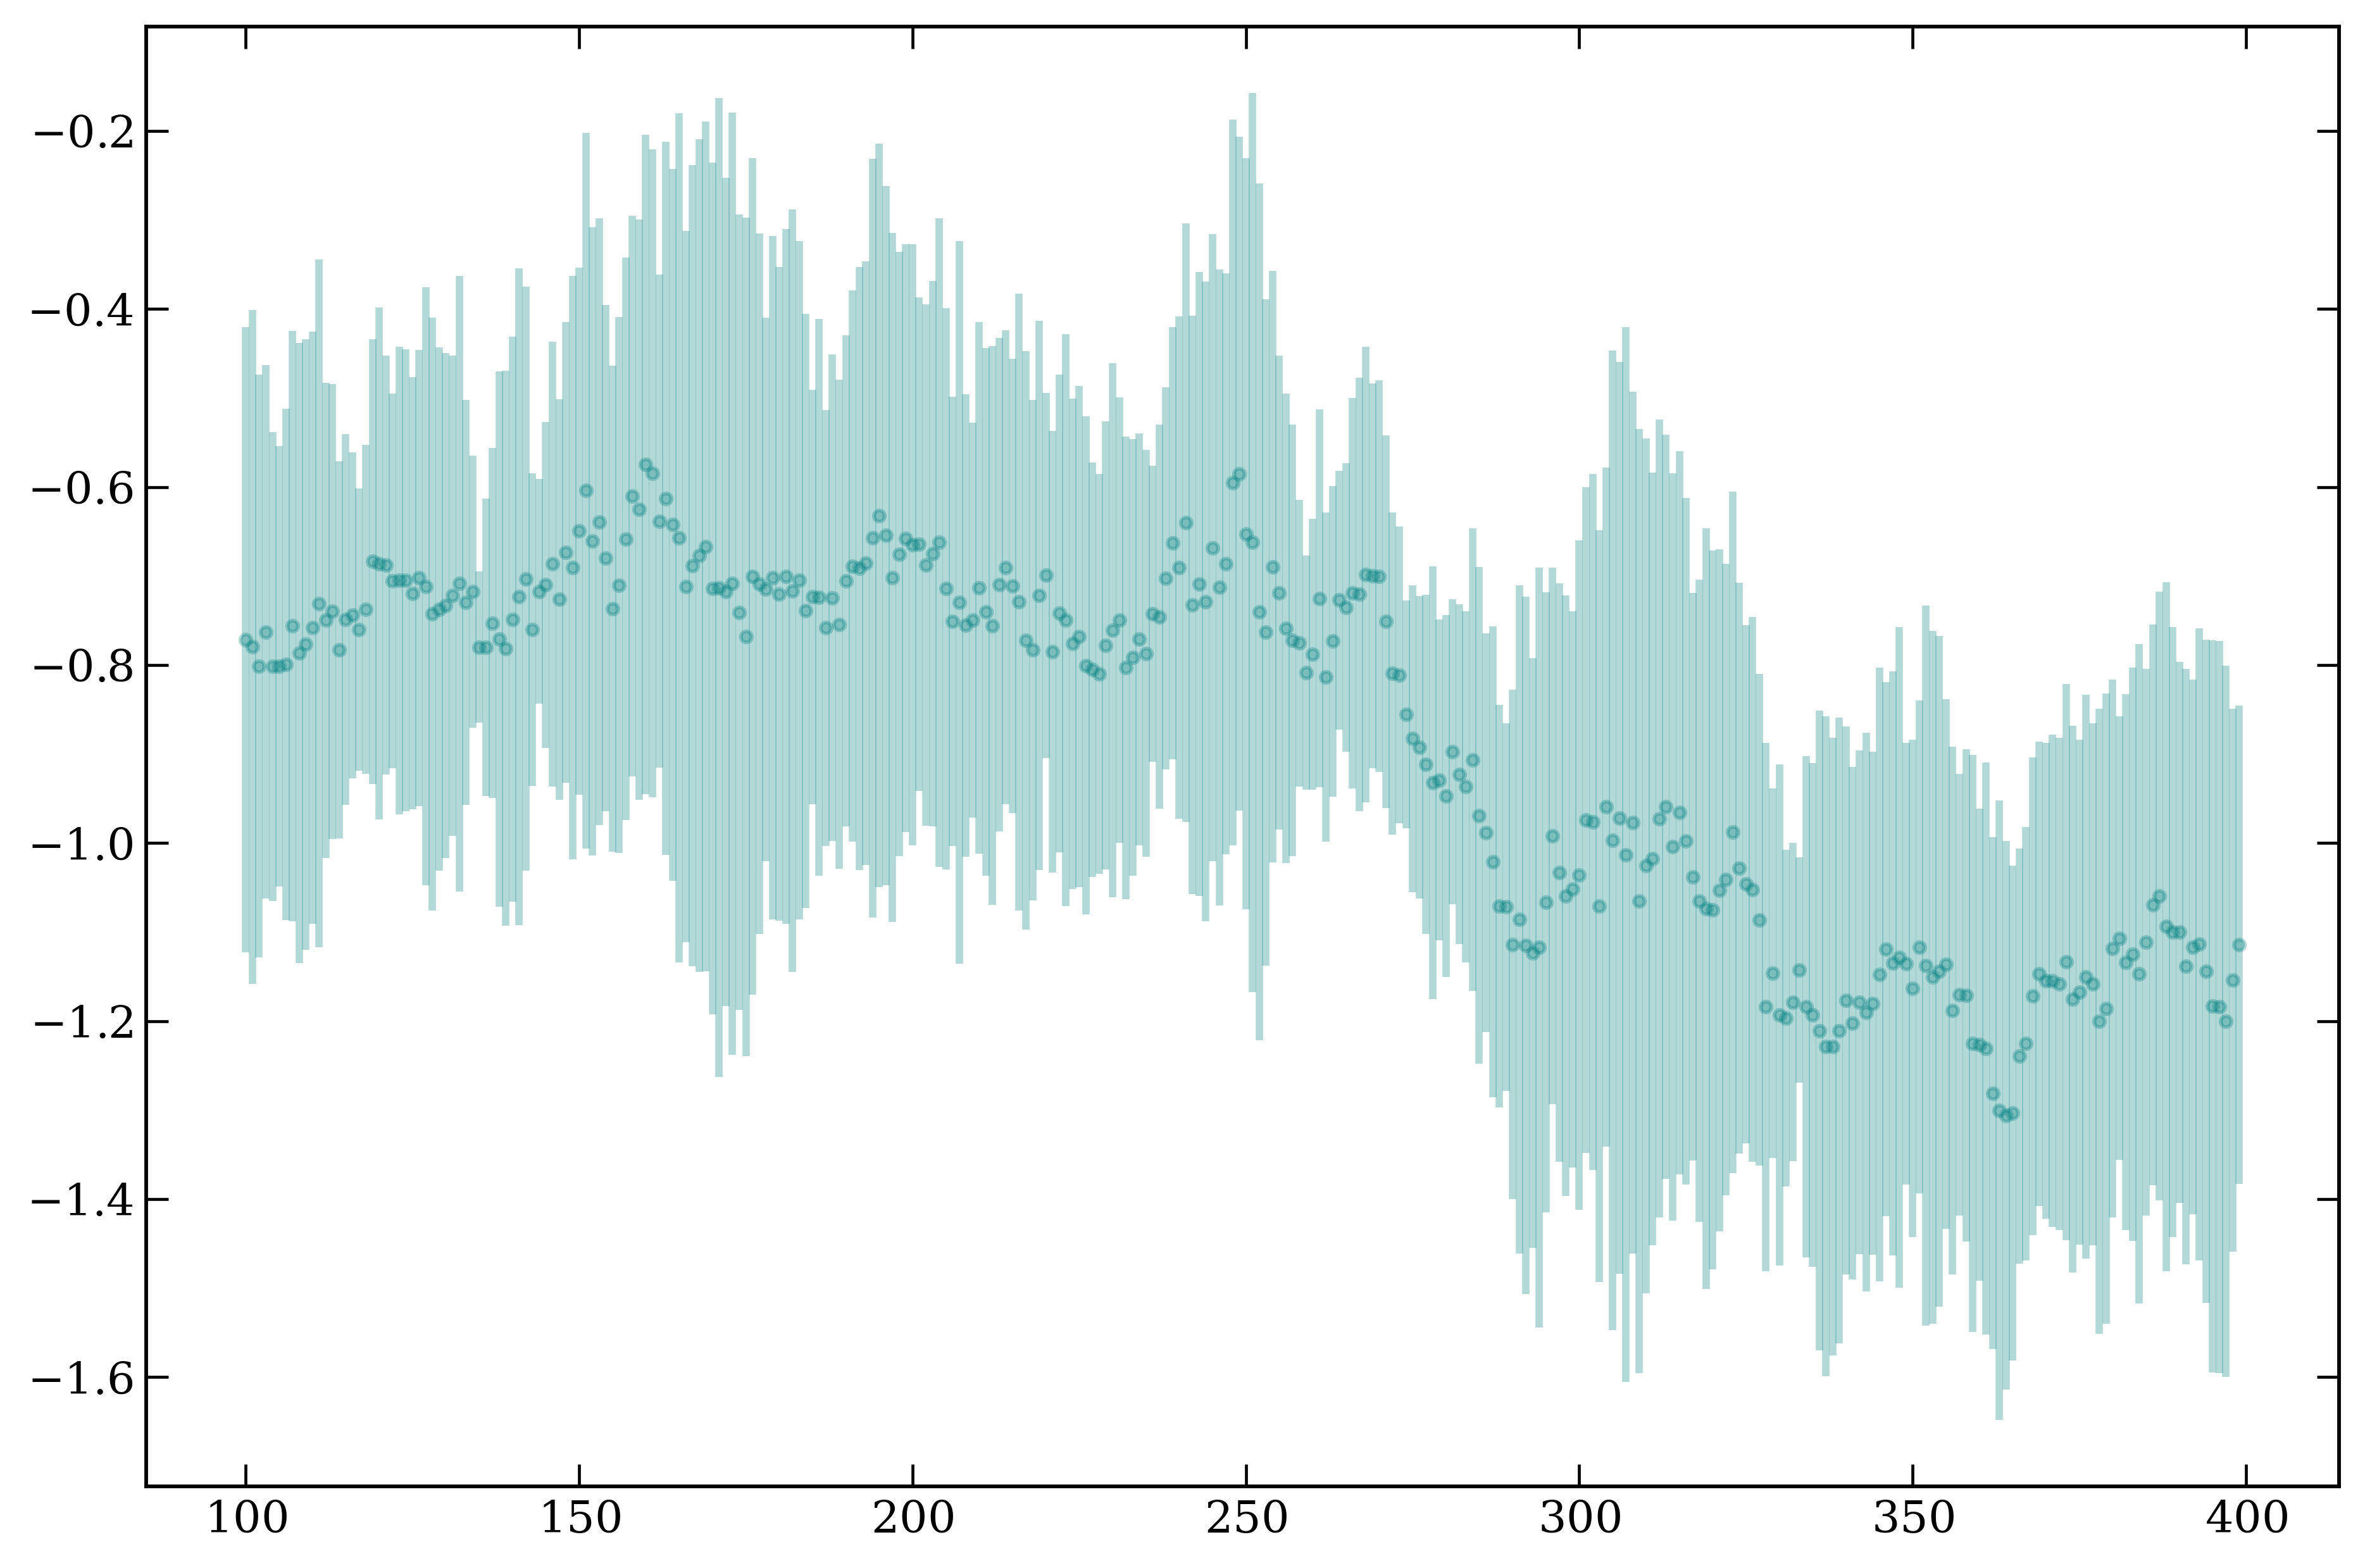

In [11]:
fit_params = np.load(os.path.join(ad.output_paths[-1], 'fit_params_sfac.npy'))
act_list = ad.act_list[-1]
act = 0.022
act_idx = act_list.index(act) 

fig, ax = plt.subplots()

X=np.arange(fit_params.shape[0])

ax.errorbar(X, y=fit_params[:,act_idx,0], yerr=fit_params[:,act_idx,-1],fmt='.', alpha=.3, label='fit_params')

Text(0.02, 0.54, '$\\sim k^{0.2}$')

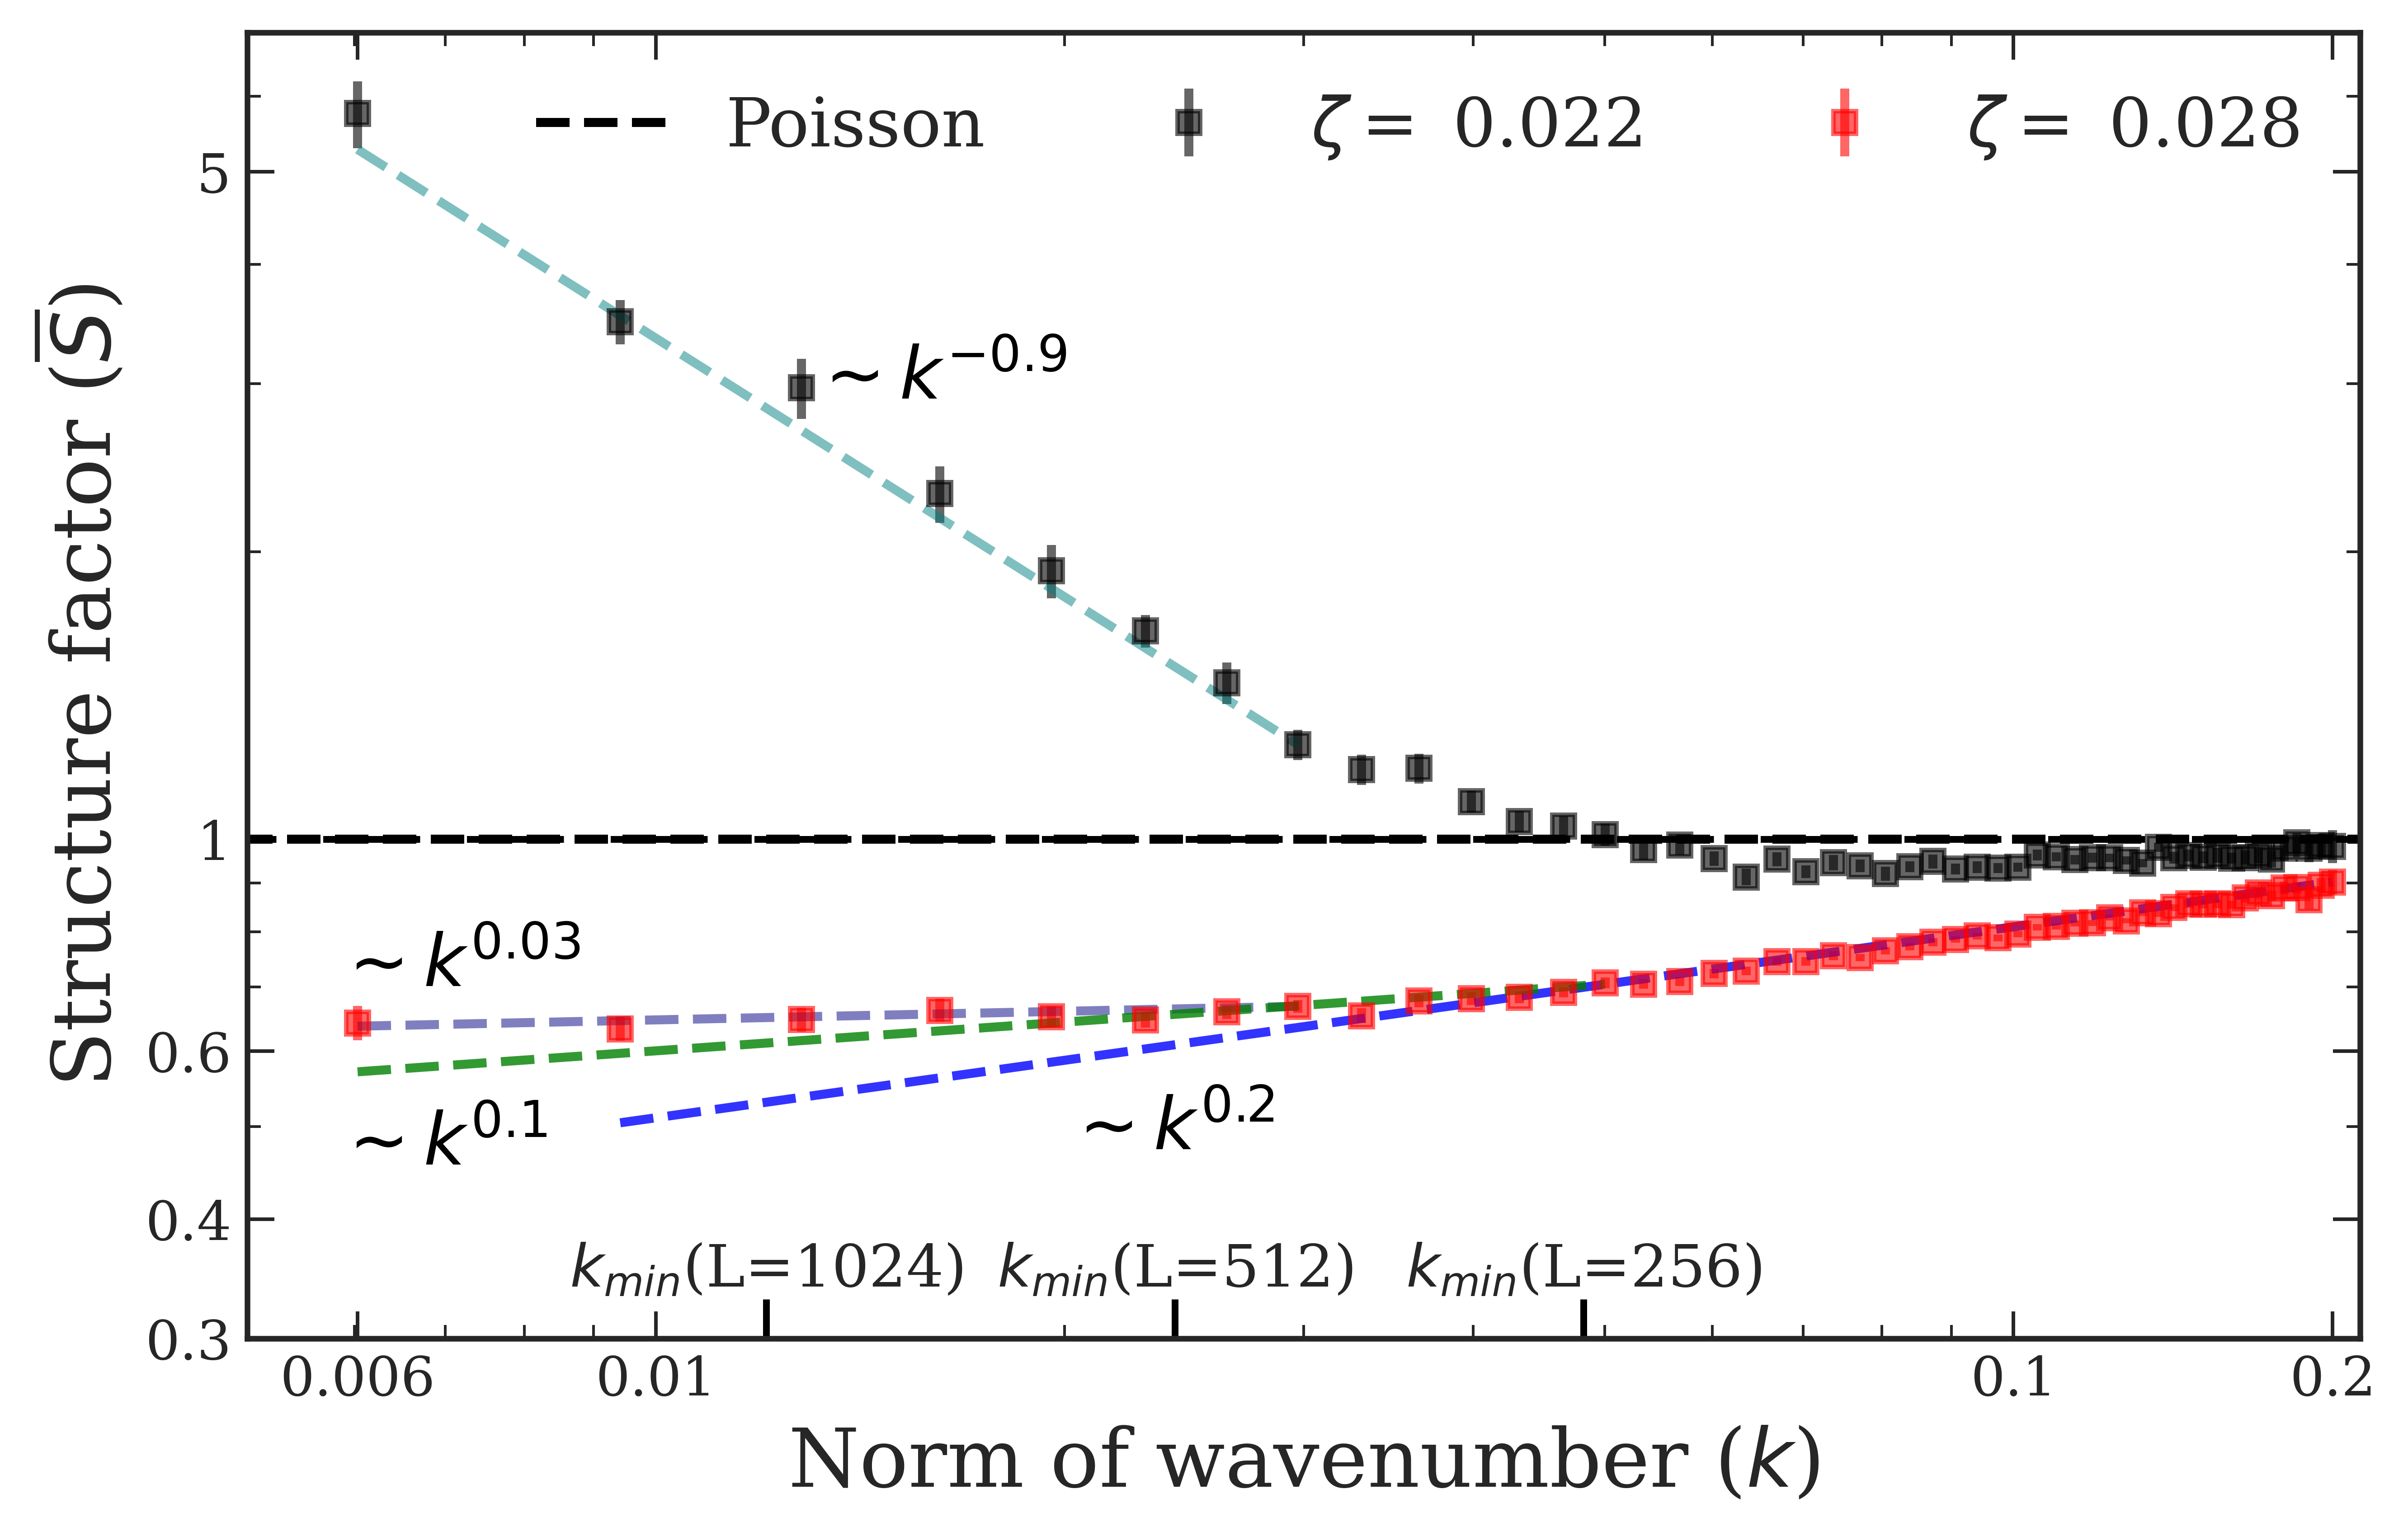

In [56]:
#kmin_list is the smallest k for each L
kmin_list = []
for L in ada.LX:
    kbins = ada.get_sfac(LX=L,time_av=True)[0]
    kmin_list.append(np.min(kbins))

ratio = 4.5 / 7
w = 7.5
h = w * ratio
fig, ax = plt.subplots(ncols=1,figsize=(w, h))
label_list = [r'$k^{-0.9}$', r'$k^{0.03}$']
scaling_exp_list = [float(label.split('{')[-1].split('}')[0]) for label in label_list]
axx = ada.plot_sfac_per_activity(LX = 2048, Npoints_to_fit=8, act_list=[0.022,0.028,], scaling_exp_list = scaling_exp_list, ax = ax)#act_list = [0.022, 0.024, 0.026, 0.027], weighted = True)
kbins, sfac_av = ada.get_sfac(LX=2048)[:2]

ax.set_ylabel(r'Structure factor ($\overline{S}$)')
axx.hlines(1, 0, 0.4, color = 'k', linestyle='--', lw=1.5)
axx.set_ylim([0.3, 7])
axx.set_xlim([0.005,0.18])
axx.legend(loc='upper right', ncol=2)
klabel_list = [r'$k_{min}$(L=256)', r'$k_{min}$(L=512)', r'$k_{min}$(L=1024)']
for i, kmin in enumerate(kmin_list[:-1]):
    axx.vlines(kmin, 0.3, .33, color = 'k', linestyle='-', lw=1.5)
    axx.text(kmin, 0.33, klabel_list[i], fontsize=13, verticalalignment='bottom', horizontalalignment='center')
#axx.text(0.7, 0.2, r'L = 1024', transform=axx.transAxes, fontsize=16, verticalalignment='top', fontweight='normal')
#axx.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

act_idx = ada.act_list[ada.LX.index(2048)].index(0.028)
x = kbins[1:50]
x2 = kbins[0:14]
scaling_exp = .2
scaling_exp2 = .1
axx.plot(x, (sfac_av[-1,act_idx,0]-0.00) * x**scaling_exp / x[-1]**scaling_exp, '--',lw=2, alpha=.8, color='blue')
axx.plot(x2, (sfac_av[len(x2),act_idx,0]+0.0) * x2**scaling_exp2 / x2[-1]**scaling_exp2, '--',lw=2, alpha=.8, color='green')
axx.legend(ncol=3)
fig.dpi = 720

ax.text(0.013, 3.3, r'$\sim k^{-0.9}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
ax.text(0.0058, 0.8, r'$\sim k^{0.03}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
ax.text(0.0058, 0.52, r'$\sim k^{0.1}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
ax.text(0.02, 0.54, r'$\sim k^{0.2}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')

C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


True
ndof chi2 prop:  2 0.26065760848049685 0.8778067568807569
$\kappa$:  0.5603599728806111 +/- 0.15938228891852985
$\alpha_{c,\inf}$:  -0.9428986321004797 +/- 0.07939905687158567


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


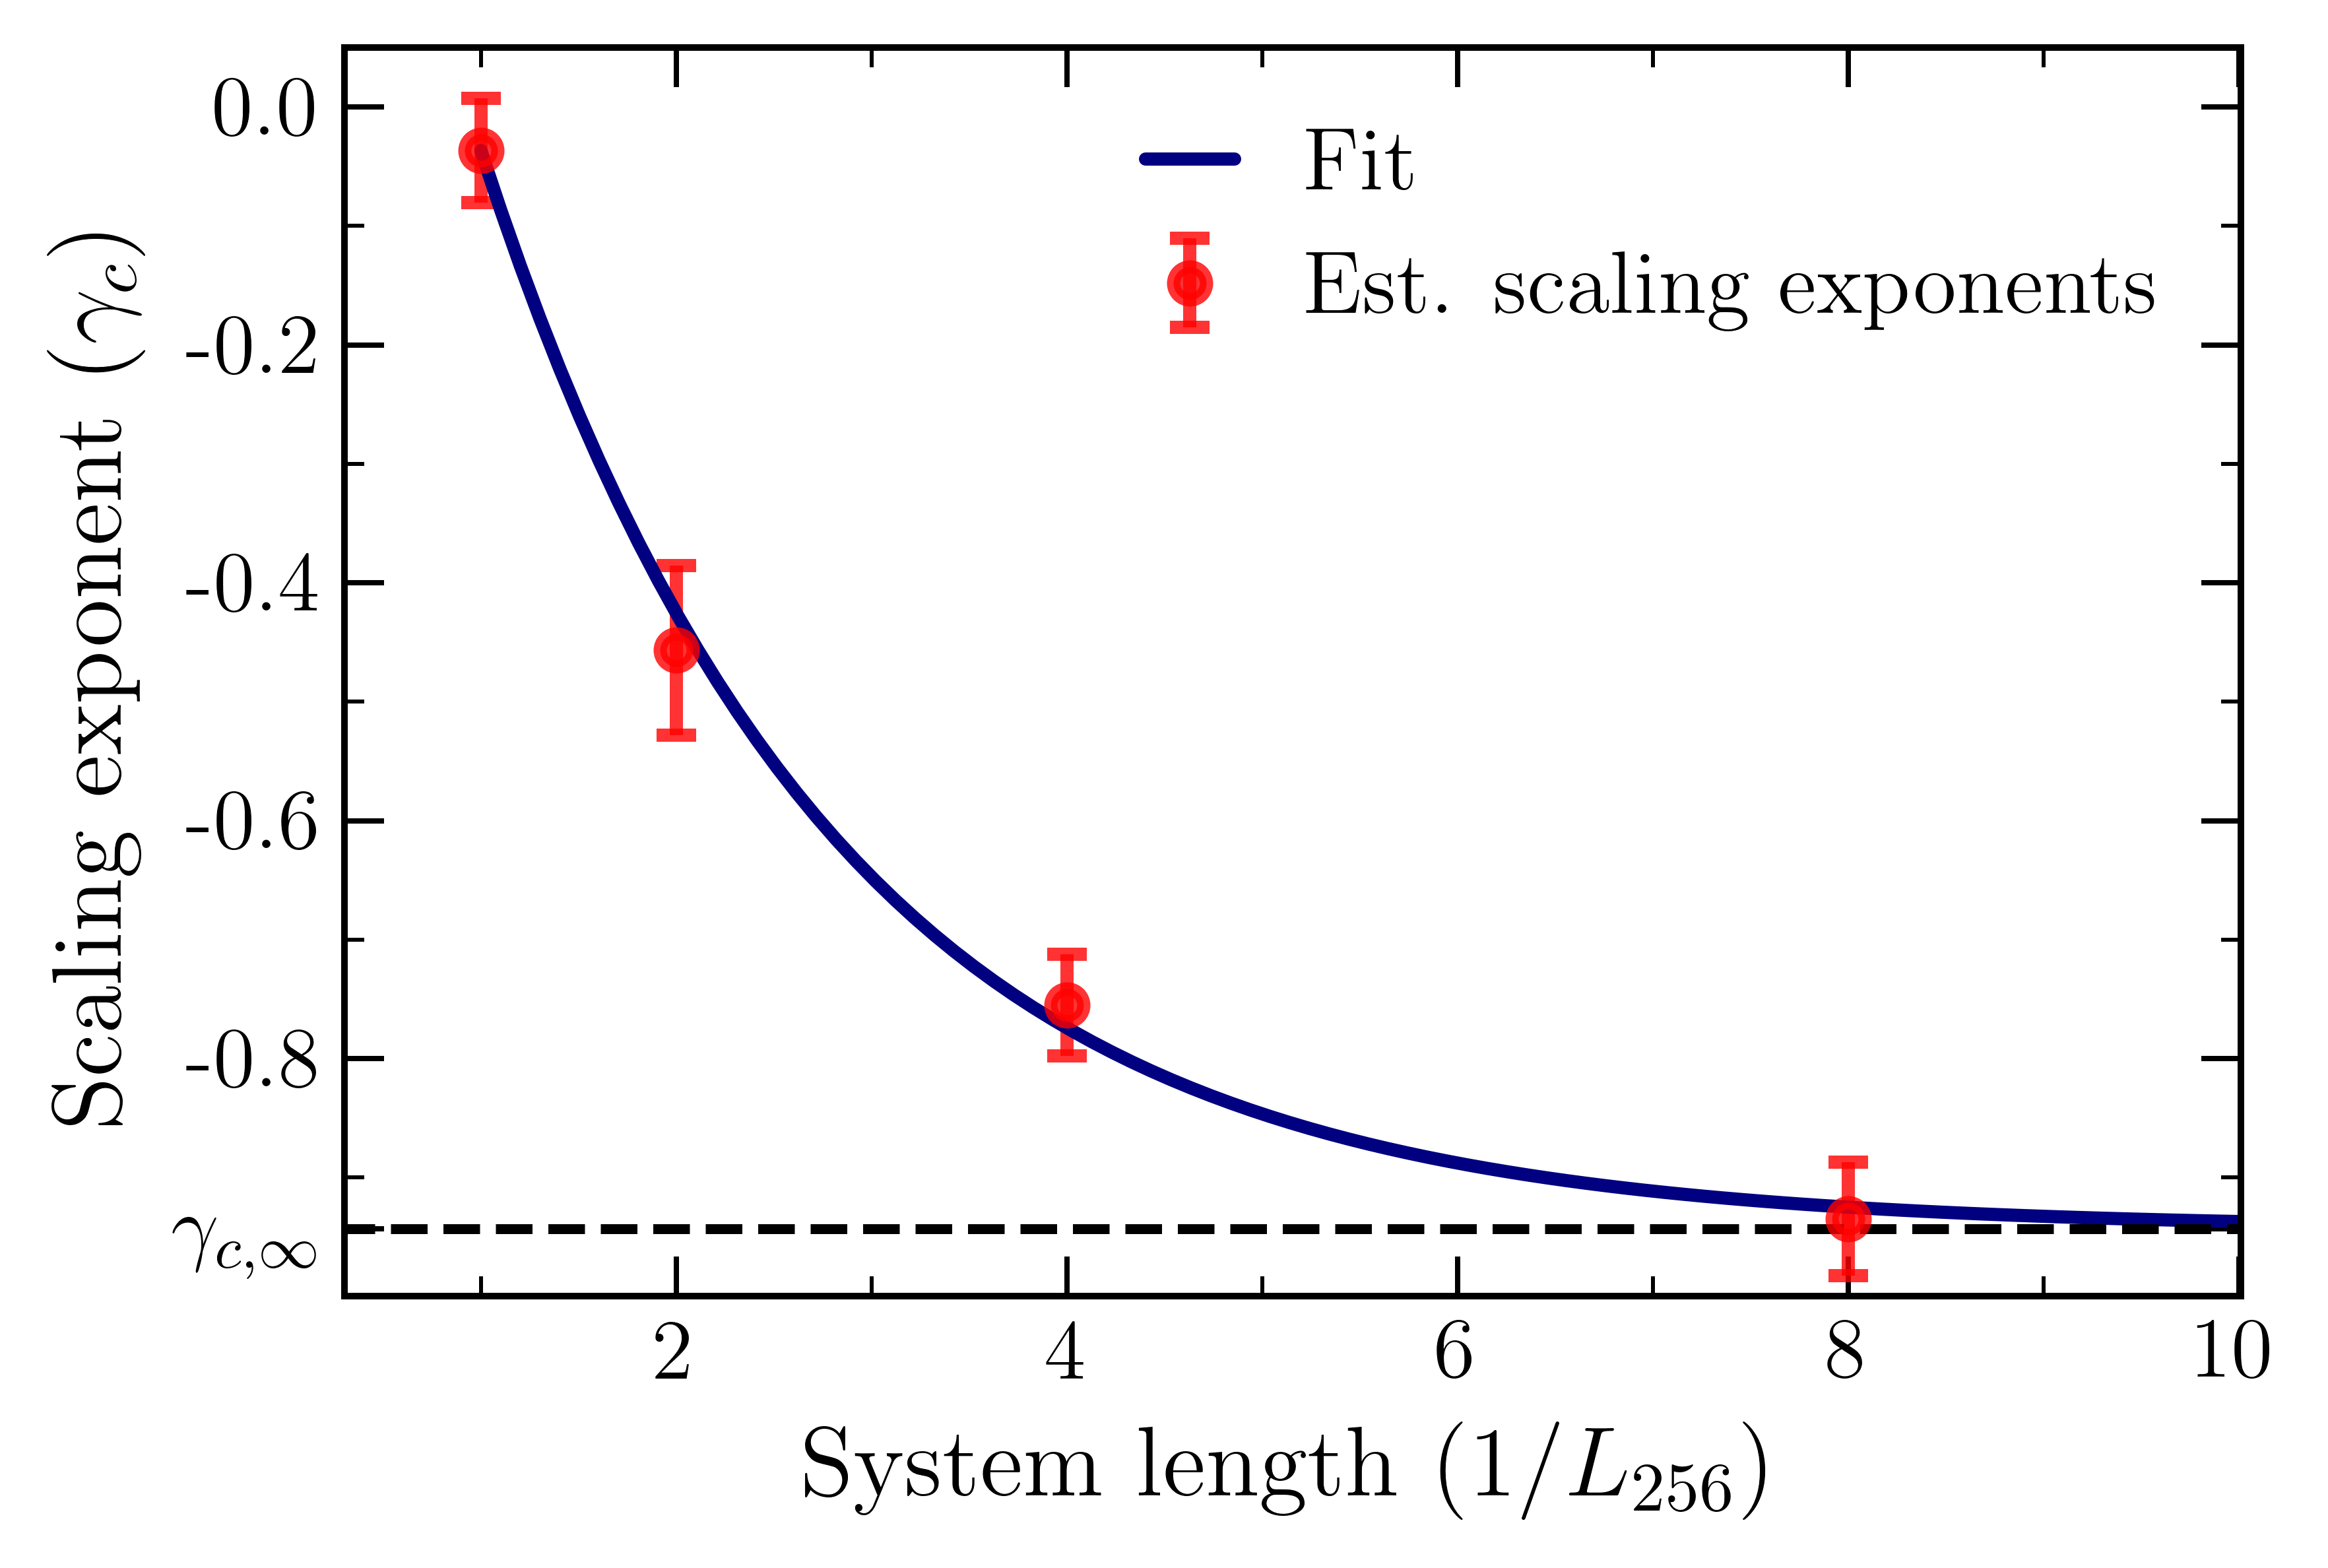

In [6]:
plt.rcParams.update({'legend.handlelength': 1, "text.usetex": True})

time_av_of_fits = False

av_of_fits, fit_params_of_av = ada.get_alpha(LX=2048)[:2]
fit_of_av = fit_params_of_av[:,[0,2]]
act_list = ada.act_list[ada.LX.index(2048)]

fig, ax = plt.subplots(figsize=(5,3.4))
min_syst_idx = 0
acts_to_plot = [ 0.022,]
alphas = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
alphas_err = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
LX_list = ada.LX[min_syst_idx:]
for i, L in enumerate(ada.LX[min_syst_idx:]):
    act_list = ada.act_list[i+min_syst_idx]
    act_idx_list = [act_list.index(act) for act in acts_to_plot]
    av_of_fits, fit_params_of_av = ada.get_alpha(LX=L)[:2]
    alphas[:,i] = av_of_fits[act_idx_list,0] if time_av_of_fits else fit_params_of_av[act_idx_list,0] 
    alphas_err[:,i] = av_of_fits[act_idx_list,1] if time_av_of_fits else fit_params_of_av[act_idx_list,2]
norm = np.ones(4-min_syst_idx)#[1,1,1] #np.abs(alphas[:,0])
normx = LX_list[0]
LX_list_normed = [LX_list[i] / normx for i in range(4-min_syst_idx)]

for i in range(len(acts_to_plot)):
    X = np.array(LX_list_normed)
    Y = np.array(list(alphas[i]/norm[i]))
    dY = np.array(list(alphas_err[i]/norm[i]))
    cs = CubicSpline(X,Y, bc_type='natural')
    x = np.linspace(1,8,8)
    y = cs(x)
    dy = np.zeros_like(y)
    data_idx = [2, 4,5, 7]
    dy[[0, 1, 3, 7]] = dY
    zero_mask = (dy == 0)
    dy[zero_mask] = np.mean(dy[~zero_mask])

    ax.errorbar(X, Y, dY, fmt = 'o', label = rf'Est. scaling exponents', color = 'red',\
            markersize = 5, alpha = .8, elinewidth = 2, capsize = 3, markeredgewidth = 2)
    
    x0 = 0.9

    fit_func_exp = lambda x, k, c: c * (1 - np.exp(-k*(x-1)))
    fit_label2 = r'$\gamma_c(L) = \hat{\gamma}_c(L_{256}) + \gamma_{c,\infty}[1 - e^{-\hat{\kappa}(L - L_{256})}]$'
    fit_label = 'Fit'
    param_guess = [.5, -1,]
    point_bounds = [50,250]
    xlim = [0, 11]
    #ax.set(yticks = yticks, yticklabels = yticklabels, xlim=xlim)

    x_plot_fit = np.linspace(X[0],xlim[-1],100)
    fit_exp = do_chi2_fit(fit_func_exp, X, Y - Y[0], np.sqrt(dY**2 + dY[0]**2), param_guess, verbose = False)
    print(fit_exp._fmin.is_valid)

    yticks = [fit_exp.values['c'] + Y[0], -0.8, -0.6, -0.4, -0.2, 0]
    yticklabels = [r'$\gamma_{c,\infty}$', -0.8, -0.6, -0.4, -0.2, 0.0]
    ax.set_xlabel(r'System length $(1/L_{256})$', fontsize=15)
    ax.set_ylabel(r'Scaling exponent ($\gamma_c$)', fontsize=15)
    ax.plot(x_plot_fit, fit_func_exp(x_plot_fit, *fit_exp.values[:]) + Y[0], '-', color = 'navy', label = fit_label) # acts_to_plot[i]) #fit_label) #
  
    eq1 = (r"\begin{eqnarray*}"
       r"|\nabla\phi| &=& 1,\\"
       r"\frac{\partial \phi}{\partial t} + U|\nabla \phi| &=& 0 "
       r"\end{eqnarray*}")
    eq1 = (r"\begin{eqnarray*}"
      #r"|\nabla\phi| &=& 1,\\"
      # r"\frac{\partial \phi}{\partial t} + U|\nabla \phi| &=& 0 "
       r"\end{eqnarray*}")
    
    fit_label2 = (r'$\gamma_c(L) = \hat{\gamma}_c(L_{256}),\\$' \
                r'$+ \gamma_{c,\infty}[1 - e^{-\hat{\kappa}(L - L_{256})}]$')
    
    text = r"$\begin{array}{c} \gamma_c(L) = \hat{\gamma}_c(L_{256}) \\ + \gamma_{c,\infty}[1 - e^{-\hat{\kappa}(L - L_{256})}] \end{array}$"
    #ax.text(2.3, -0.3, text, color="navy", fontsize=14,
    #horizontalalignment="right", verticalalignment="top")


    ax.set(yticks = yticks, yticklabels = yticklabels, ylim=[-1,.05])#xlim=[0,40])
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    ax.hlines(fit_exp.values['c'] + Y[0], 0,xlim[-1], lw=1.5,color = 'black', linestyle = '--',)# label = rf'$\alpha_c = {(fit_exp.values["c"]+Y[0]):.2f}$')
    Ndof, chi2, prop = get_statistics_from_fit(fit_exp, len(X),)
    print("ndof chi2 prop: ", Ndof, chi2, prop)
    #ax.set_yscale(('log'))
    ax.legend(fontsize=13.5, loc='upper right')
    fig.tight_layout()
    fig.dpi = 720
    #ax.set_xscale('log', base=2)
    print(r"$\kappa$: ", fit_exp.values['k'], "+/-", fit_exp.errors['k'])  
    print(r"$\alpha_{c,\inf}$: ", fit_exp.values['c'] + Y[0], "+/-", fit_exp.errors['c'])
    #print(fit_exp.values['L0'], "+/-", fit_exp.errors['L0'])
ax.tick_params(axis='both',which='major', labelsize=13)
ax.set_xlim([0.3, 10.01])
    #fig.dpi = 100 #720
fig.tight_layout()
save_path = "C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Figures\\article\\alpha_scaling.jpeg"
save_path_eps = "C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Figures\\article\\alpha_scaling.eps"
fig.savefig(save_path, dpi=520)
fig.savefig(save_path_eps, ) #dpi=520)

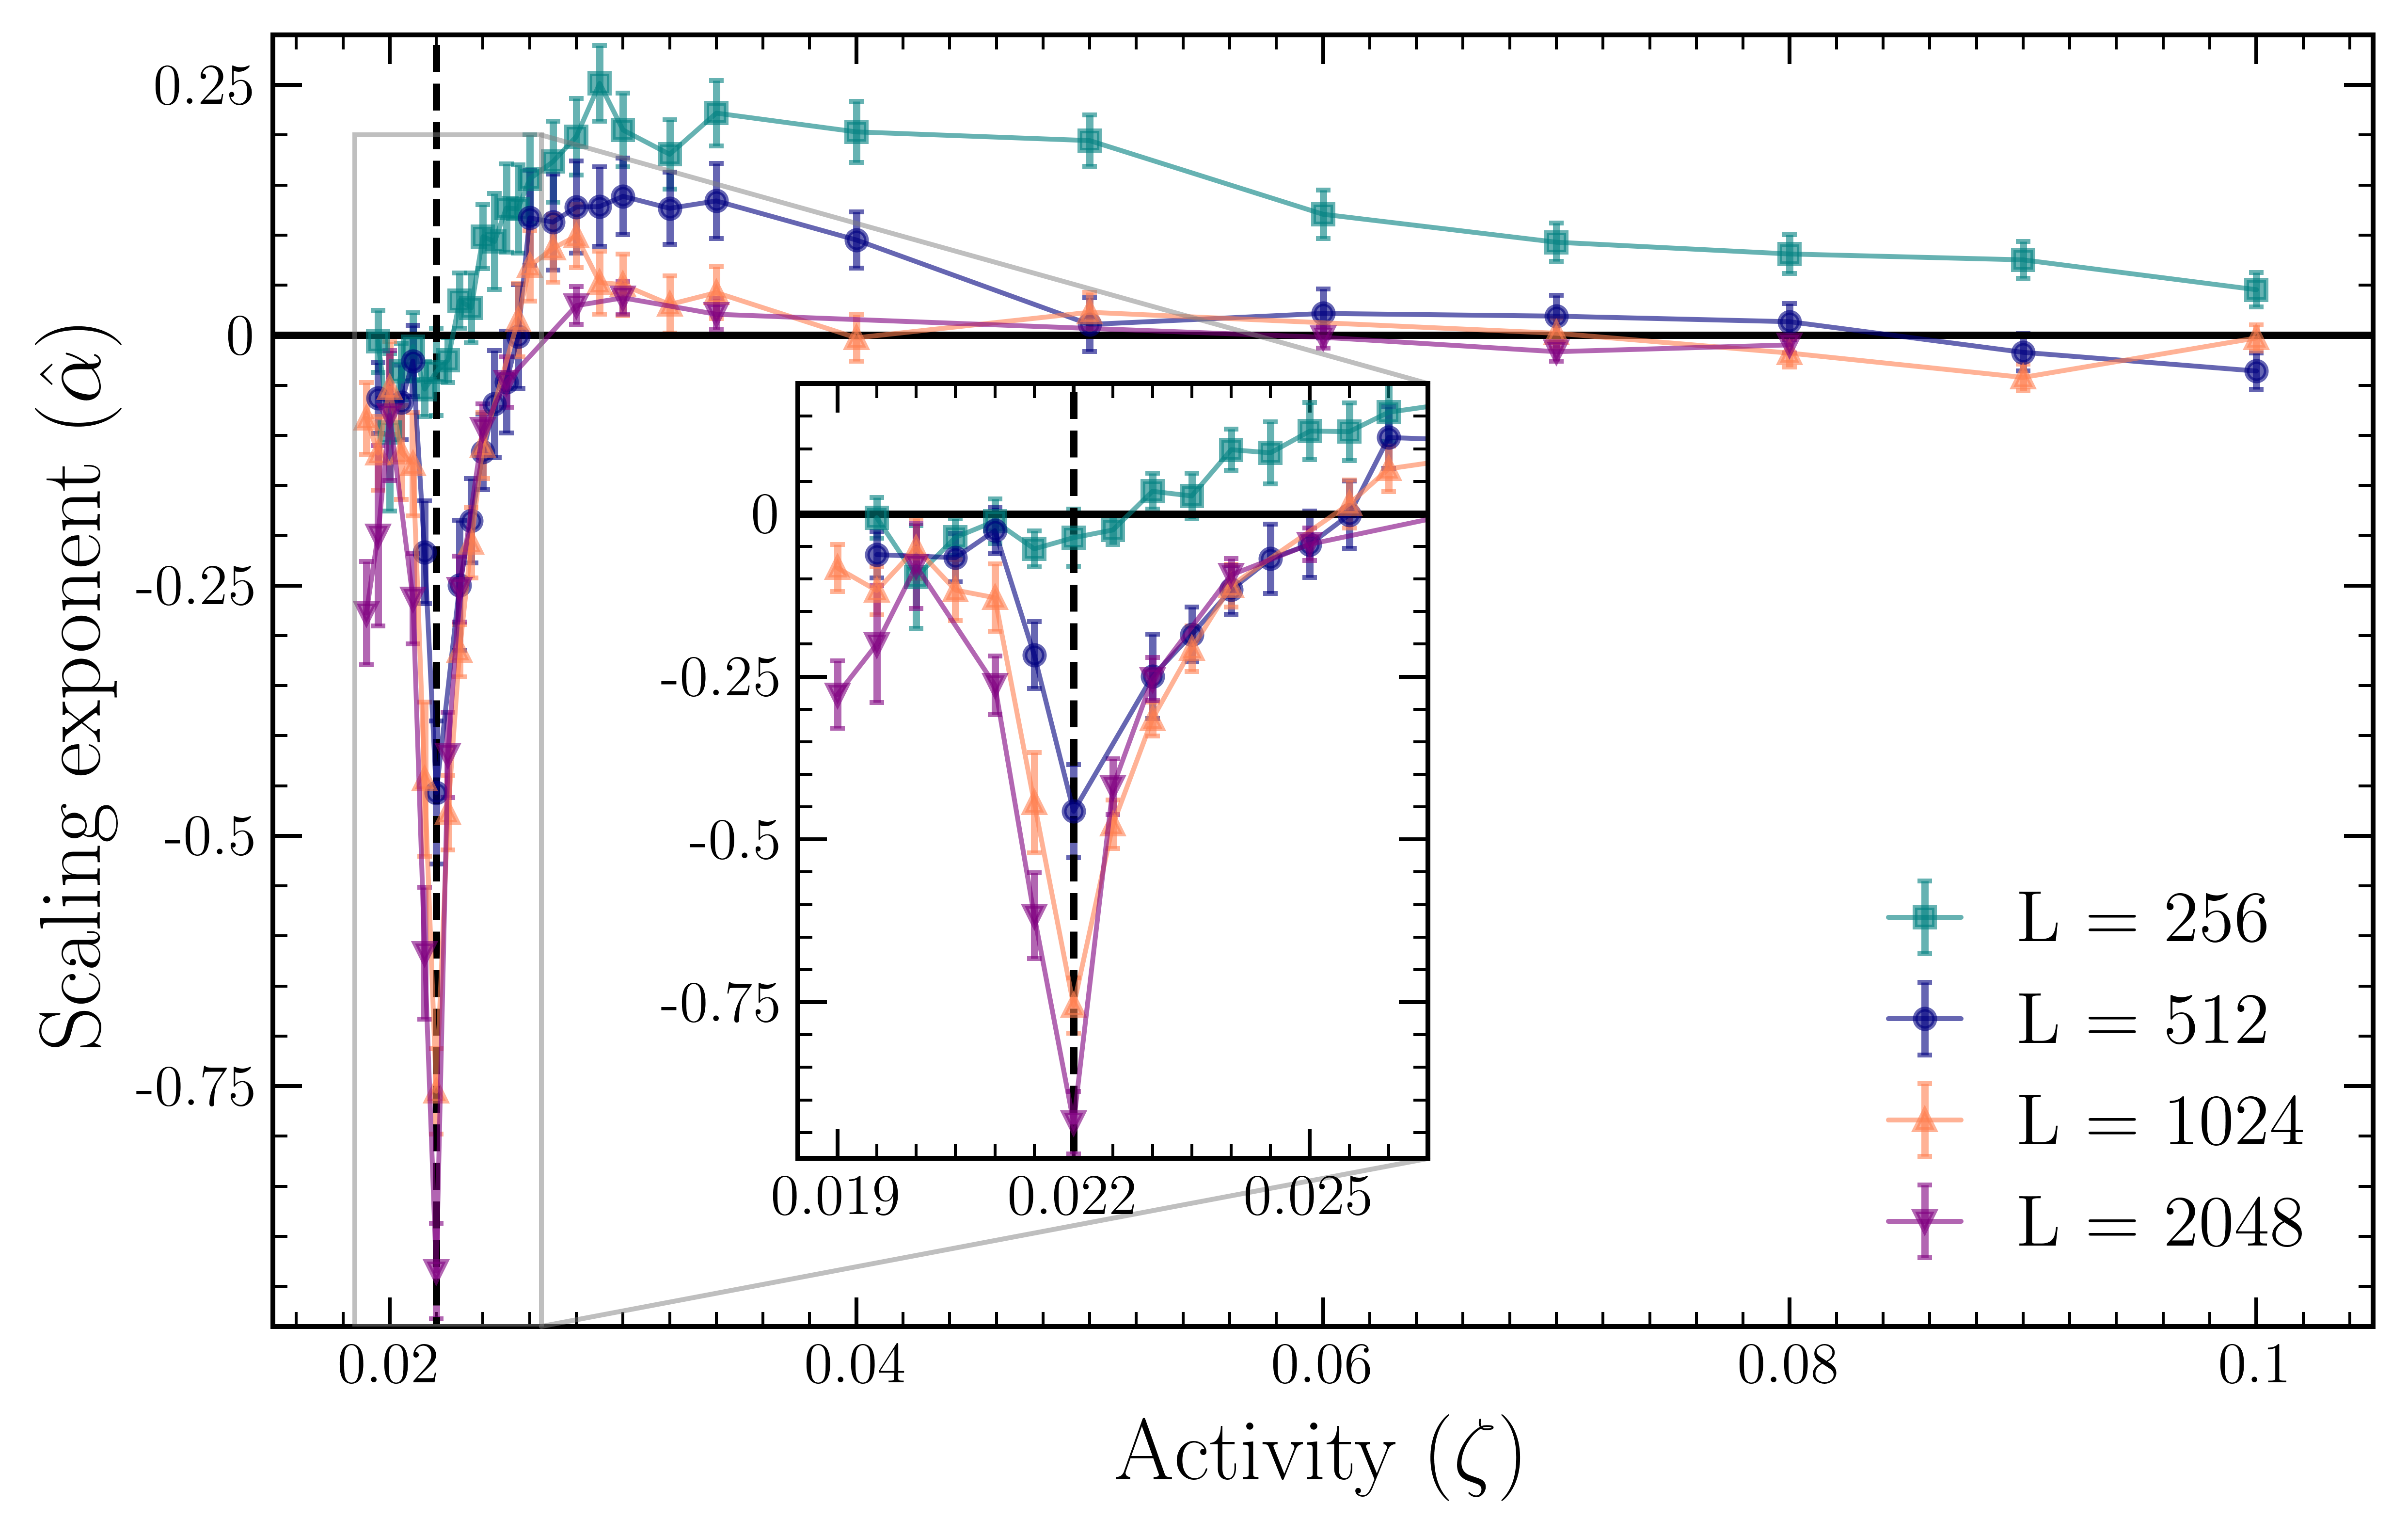

In [287]:

fig, ax = plt.subplots(figsize=(7, 4.5)) 

peak1 = 0.022
peak2 = 0.028

xmin = 0.25
ymin = 0.13
width = 0.3
inset_box = [xmin, ymin,1*width,2*width]

plot_fit_of_time_av = True
ax1, axin1 = ada.plot_alpha_mean_sfac(time_av=plot_fit_of_time_av,  ax = ax, inset_box = inset_box)


ax1_xlims = [0.015, 0.105]
ax1_ylims = [-.99, 0.3]
axin1_xlims = [0.0185, 0.0265] #[0.019, 0.035]
axin1_ylims = [ax1_ylims[0], .2] #[-.82, 0.3]


yticks = [-1.25, -1, -.75, -.5, -.25, 0, 0.25, 0.5]
axin1_yticks =  [-1.25, -1, -.75, -.5, -.25, 0, 0.25,]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
axin1_xticks = np.round(np.linspace(axin1_xlims[0]+0.001, axin1_xlims[1] - 0.001,3), 3)
axin1_xticks = [0.019, 0.022, 0.025]
ax1.set(xticks=xticks, yticks=yticks, xticklabels=xticks, yticklabels=yticks, xlim=ax1_xlims, ylim=ax1_ylims)
axin1.set(xticks=axin1_xticks, yticks=axin1_yticks, xticklabels=axin1_xticks, yticklabels=axin1_yticks, xlim=axin1_xlims, ylim=axin1_ylims)

ax1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

ax1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
axin1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
ax1.indicate_inset_zoom(axin1,)
ax1.set_ylabel(r'Scaling exponent ($\hat{\alpha}$)', labelpad=3)

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axin1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axin1.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))


ax.legend()
ax1.set_xlabel(r'Activity ($\zeta$)')
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/hyperuniformity.png', dpi = 420, pad_inches = .5)
